# Uwagi

- agglomerative clustering nie ma funkcji predict, tylko fit_predict, nie mozna wiec wytrenowac go na danych modelarzy i przetestowac na walidacyjnych
- zbiór walidacyjny dzieli tylko na 2 części
- polaczony zbior wal i modelarski dają inne wyniki i interpretacje klastrów

# Testy

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.manifold import TSNE

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from functools import partial

C:\Users\bartekb\AppData\Local\Temp\ipykernel_21552\1629838151.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
         self.scaler = [MinMaxScaler() for _ in range(len(classes))]
         self.classes = classes
         
    def fit(self, X, y=None):
            for i,col in enumerate(self.classes):
                self.scaler[i].fit(X[[col]])
            return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        for i,col in enumerate(self.classes):
             Xc[col] = self.scaler[i].transform(Xc[[col]])
        return Xc

class transformer_3(BaseEstimator, TransformerMixin):
    
    def fit(self,df,y= None):
        return self
    
    def transform(self,X,y= None):
    
        X_copy = X.copy()

        # Resolution correction
        mask = X_copy.resolution_width <= X_copy.resolution_height
        X_copy.loc[mask,["resolution_width","resolution_height"]] = X_copy.loc[mask,["resolution_height","resolution_width"]].values

        # Processor tier
        new_column=X_copy['processor_tier'].str.extract(r'(\d)')
        new_column=new_column.fillna(0)
        X_copy['processor_tier']=new_column

        # Poprawa walidatorska
        test_os = ['windows' 'dos' 'mac' 'chrome' 'other']
        X_copy['OS'] = X_copy['OS'].apply(lambda x: x if x in test_os else 'other')

        # One Hot Encoding
        diff1 = pd.get_dummies(X_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')


        # OHEncoding brands
        brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
        X_copy['brand'] = X_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
        diff2 = pd.get_dummies(X_copy[['brand']],dtype='int')
        X_copy = pd.concat([X_copy,diff1,diff2],axis=1)
        X_copy = X_copy.drop(['index','Model','brand','OS','processor_brand','gpu_brand','gpu_type'],axis=1)

        # Correcting types
        X_copy.is_touch_screen = X_copy.is_touch_screen + 0
        X_copy.primary_storage_type = (X_copy.primary_storage_type=='SSD') + 0

        # Price to log
        X_copy['Price'] = np.log(X_copy['Price'] )

        # year_of_warranty
        mask_year_of_war_no =X_copy.year_of_warranty=='No information'
        X_copy.loc[mask_year_of_war_no,['year_of_warranty']] = 0
        X_copy['year_of_warranty'] = X_copy['year_of_warranty'].apply(lambda x : int(x))
        X_copy['year_of_warranty_other'] = mask_year_of_war_no + 0

        # secondary_storage_type drop
        X_copy = X_copy.drop('secondary_storage_type',axis=1)

        # other transformations 
        X_copy['primary_storage_capacity'] = np.log2(X_copy.primary_storage_capacity)
        X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
        X_copy['resolution_width']  = np.log(X_copy.resolution_width)
        X_copy['resolution_height'] = np.log(X_copy.resolution_height) 
        X_copy['Rating'] = X_copy['Rating']/100

        # for i,col in enumerate(self.classes):
        #     X_copy[col] = self.minmax[i].fit_transform(X_copy[[col]])
        

        return X_copy

In [4]:
classess = ['Price','resolution_width','resolution_height','display_size','processor_tier','num_cores','num_threads',
            'ram_memory','primary_storage_capacity','secondary_storage_capacity']

agg_model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=20)

ppl = Pipeline([('transformer',transformer_3()),('minmax',MinMaxTransformer(classess))])

In [23]:
data_modelers = pd.read_csv('../../data/modelers_data.csv')
data_validate = pd.read_csv('../../data/validators_data.csv')
data_validate = pd.concat([data_modelers, data_validate])

In [24]:
print(data_validate['OS'].unique())
print(data_modelers['OS'].unique())

['windows' 'dos' 'mac' 'chrome' 'other' 'android' 'ubuntu']
['windows' 'dos' 'mac' 'chrome' 'other']


In [26]:
train_data = ppl.fit_transform(data_modelers)
test_data = ppl.fit_transform(data_validate)
test_clusters = agg_model.fit_predict(test_data)

C:\Users\bartekb\AppData\Local\Temp\ipykernel_21552\1600958714.py:68: RuntimeWarning: divide by zero encountered in log2
  X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
C:\Users\bartekb\AppData\Local\Temp\ipykernel_21552\1600958714.py:68: RuntimeWarning: divide by zero encountered in log2
  X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))


In [27]:
data_validate['cluster'] = test_clusters

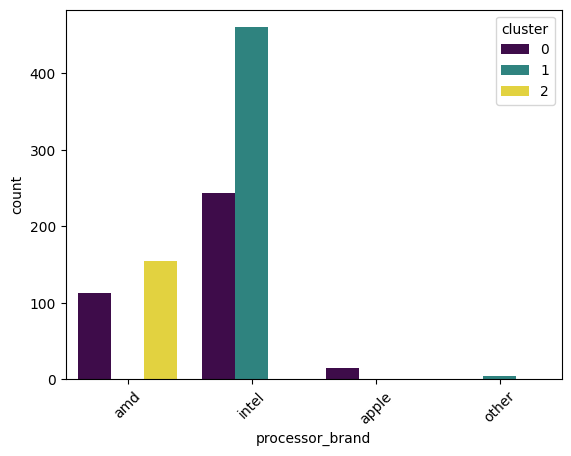

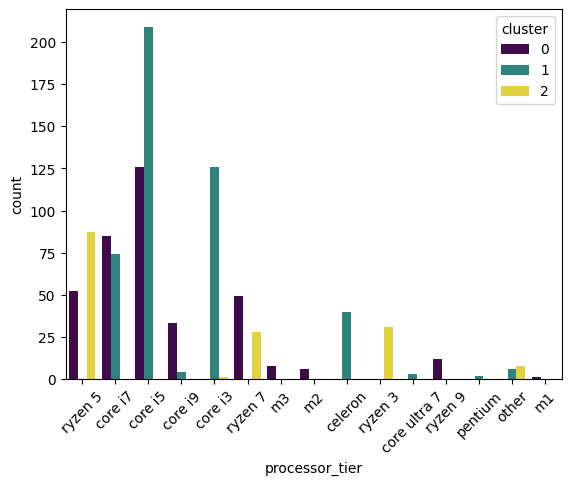

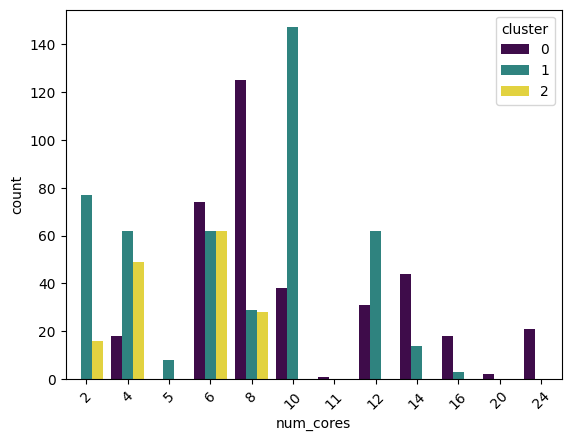

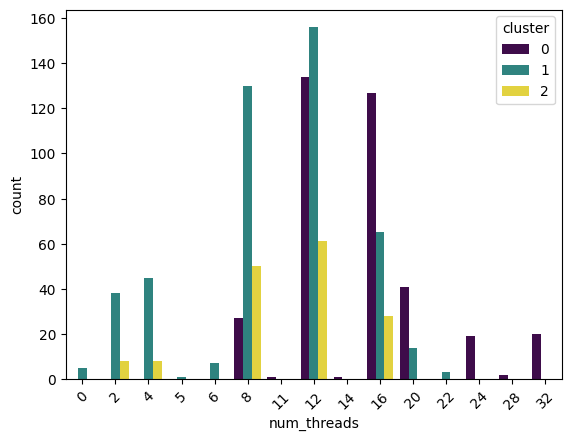

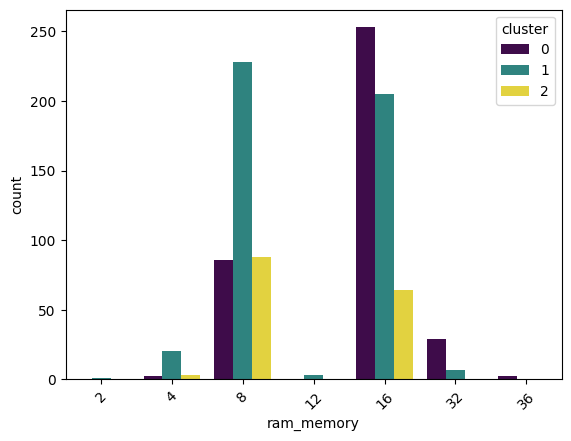

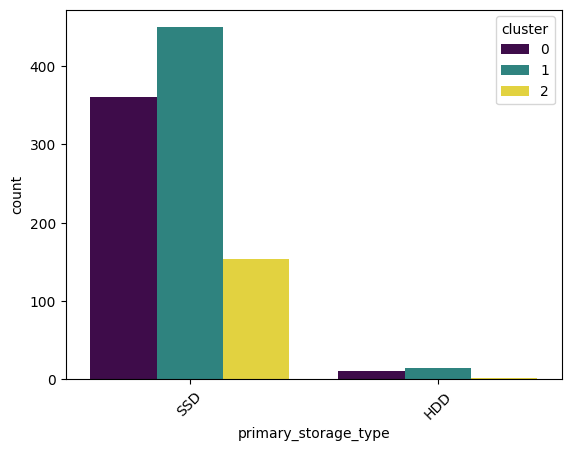

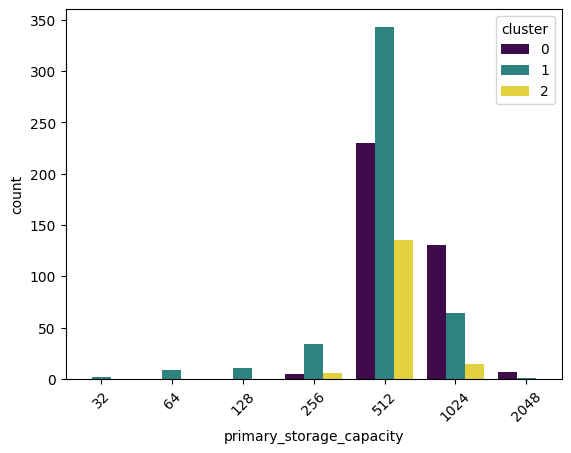

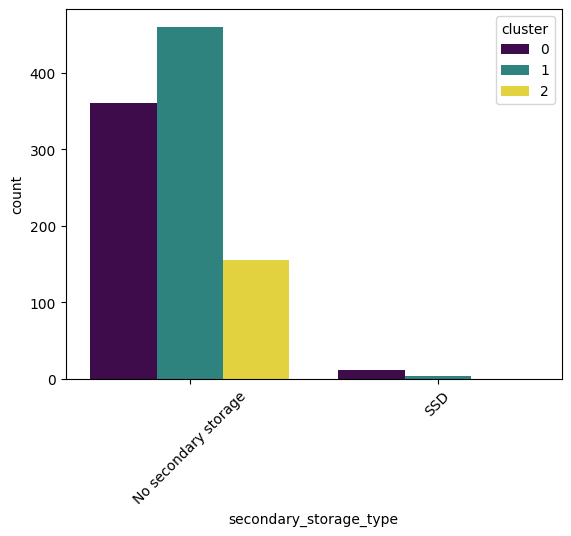

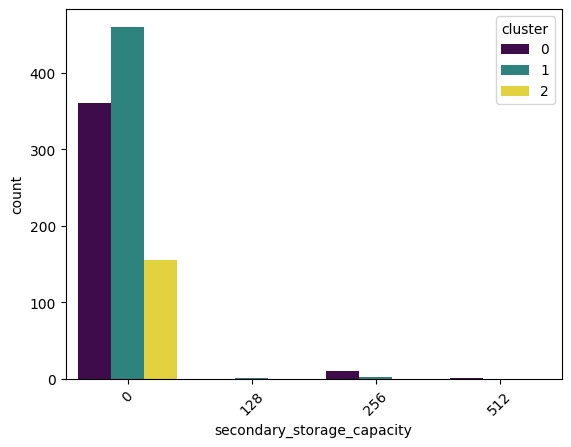

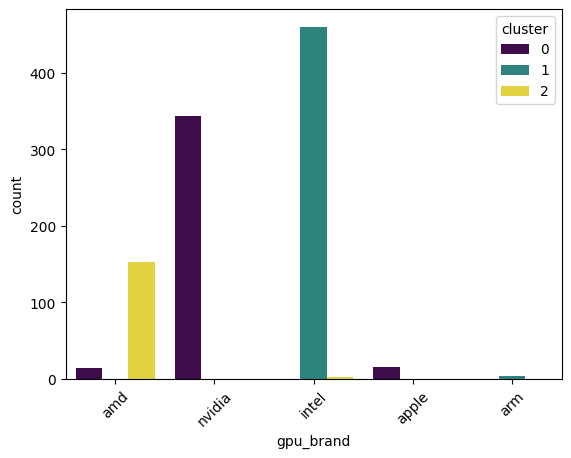

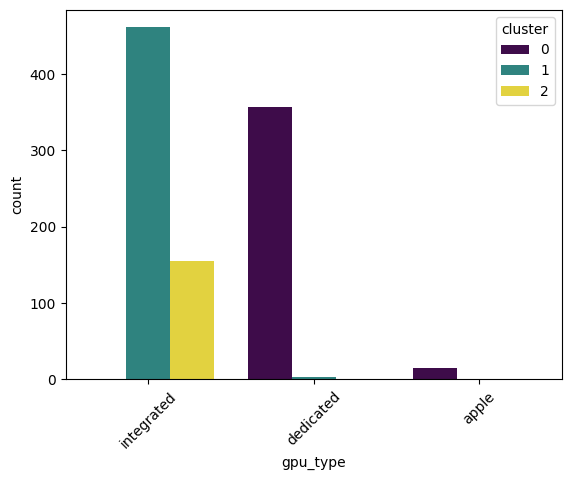

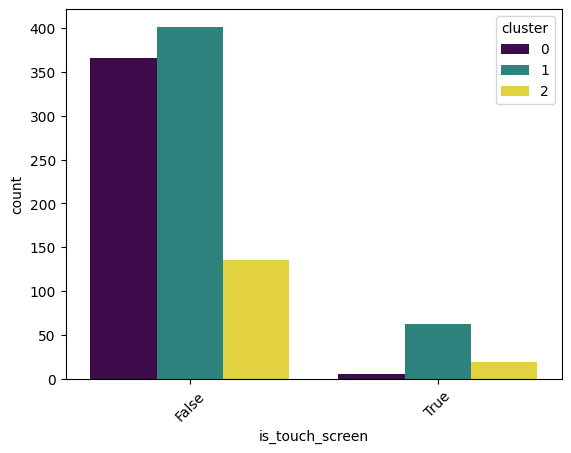

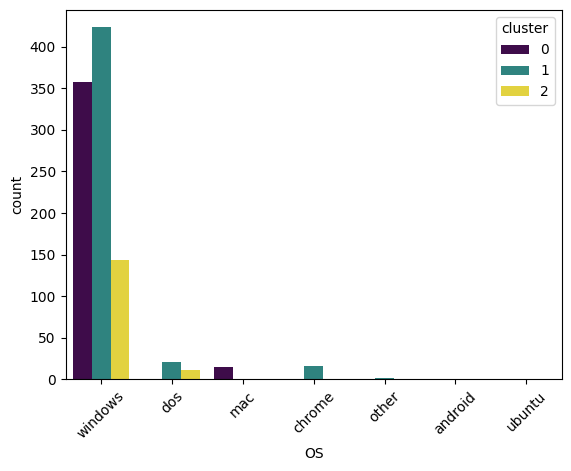

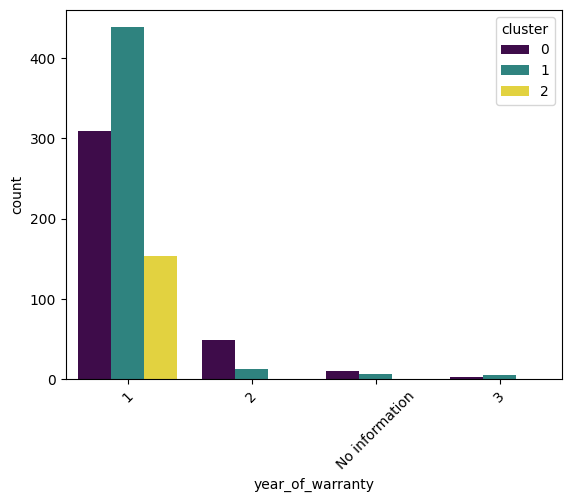

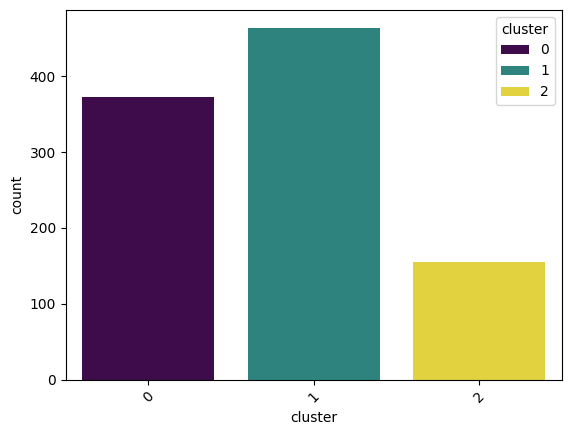

In [28]:
# take columns with less unique values than 20
discrete_columns=[]
for col in data_validate.columns:
    if len(data_validate[col].unique())<20:
        discrete_columns.append(col)
        
for col in discrete_columns:
    sns.countplot(data=data_validate,x=col,hue='cluster',palette='viridis')
    plt.xticks(rotation=45)
    plt.show()

In [30]:
def show_metrics(X,model):
    # input:
    # X = przetransformowany dataFrame
    # model = niewytrenowany model
    X = X.values
    y = model.fit_predict(X)
    silhouette = silhouette_score(X, y)
    db_index = davies_bouldin_score(X, y)
    ch_index = calinski_harabasz_score(X, y)  

    return([silhouette,db_index,ch_index])
def pca_visualization(df,clusters):
    pca = PCA(n_components=2)  
    X_pca = pca.fit_transform(df)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=clusters, palette='tab20', legend='full')
    plt.title('K-means Clustering (PCA Visualization)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()
def pca_3d(df,clusters):
    pca = PCA(n_components=3)  

    X_pca = pca.fit_transform(df)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='tab20')

    ax.set_title('K-means Clustering (3D PCA Visualization)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    legend1 = ax.legend(*scatter.legend_elements(), title='Clusters')
    ax.add_artist(legend1)

    plt.show()
def tsne_visualization(dataframe, predicted_clusters):
    tsne = TSNE(n_components=2, random_state=69)
    tsne_results = tsne.fit_transform(dataframe)
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['Cluster'] = predicted_clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='Cluster',
        palette=sns.color_palette('hsv', len(set(predicted_clusters))),
        data=tsne_df,
        legend='full',
        alpha=0.7
    )
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster')
    plt.show()

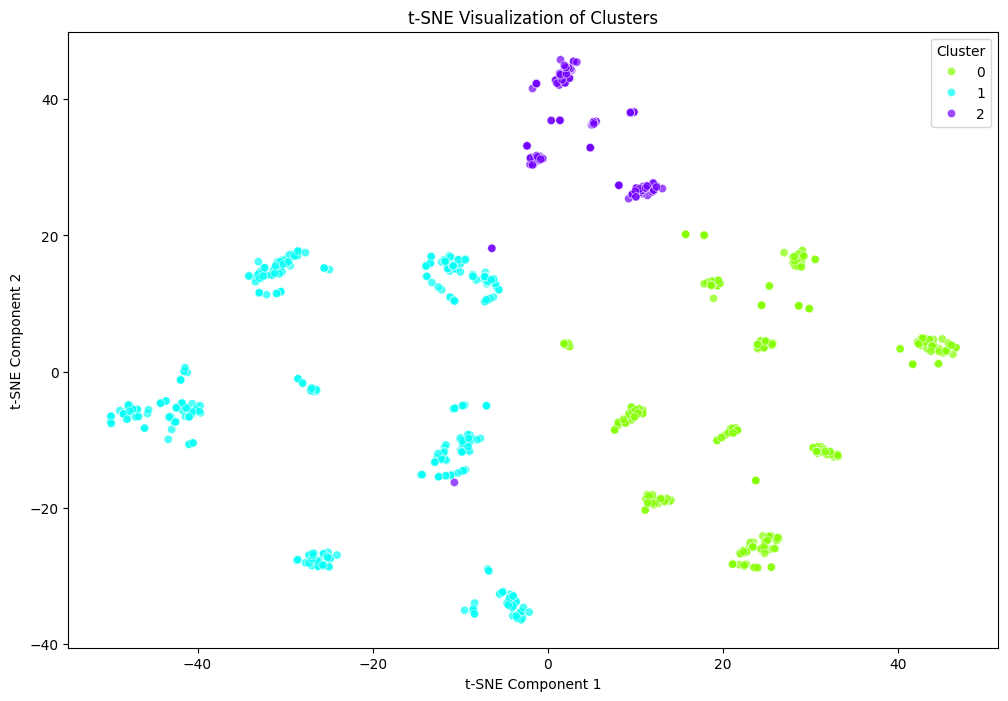

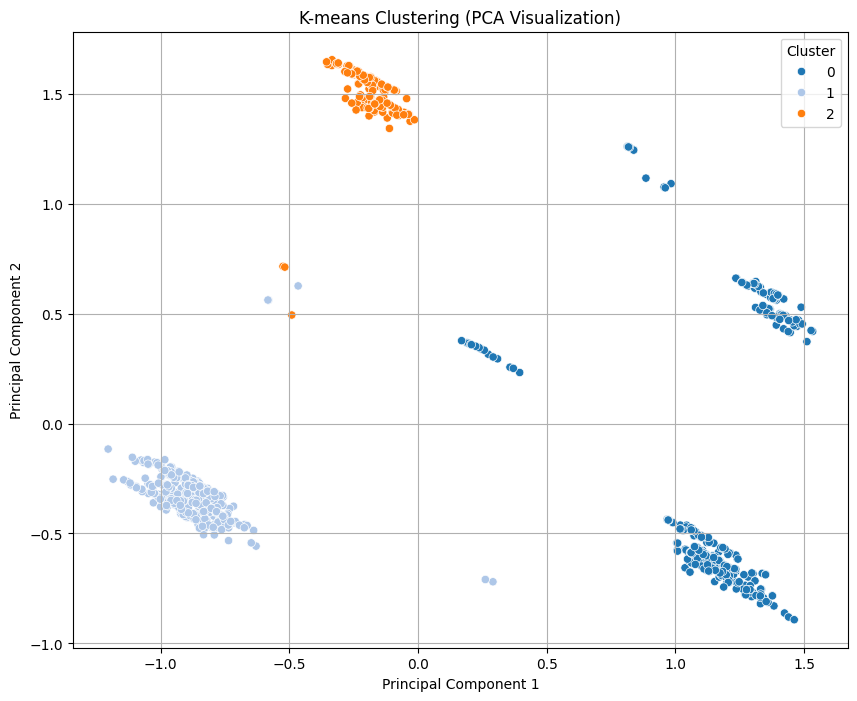

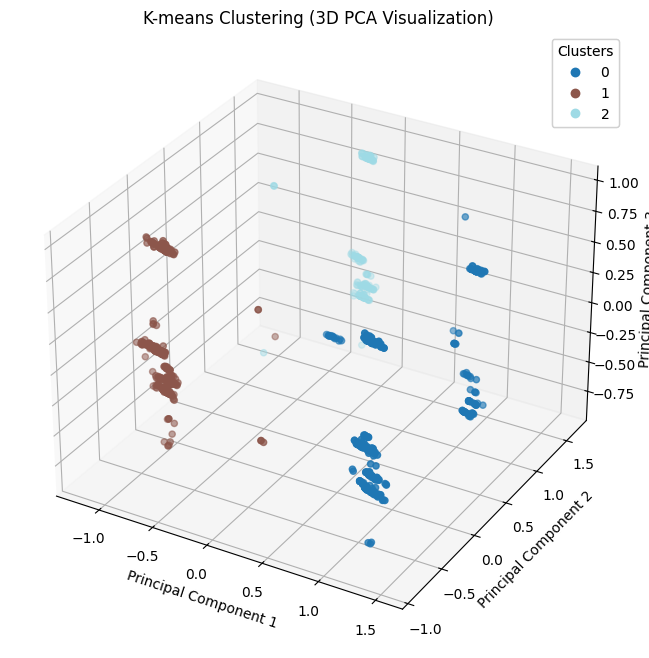

In [31]:
tsne_visualization(test_data,test_clusters)
pca_visualization(test_data,test_clusters)
pca_3d(test_data,test_clusters)

# Walidacja metryk

brak random seeda powoduje ze otrzymujemy rozne wyniki za kazdym razem. Wyniki na zbiorze tesstowym i walidacyjnym są porównywalne

In [34]:
print('wyniki na zbiorze modelarzy')
print(show_metrics(train_data,agg_model))

wyniki na zbiorze modelarzy
[0.343811295649297, 1.1692664423729333, 293.7914105909256]


# Walidacja interpretacji klastrów

In [42]:
# W tym klastrze znajdują się drogie laptopy gamingowe i apple
data_validate[data_validate.cluster == 0].head(20)

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty,cluster
1,584,msi,MSI Prestige 16 A13UCX-250IN Laptop (13th Gen ...,119990,73,intel,core i7,14,20,16,...,0,nvidia,dedicated,False,16.0,2560,1600,windows,2,0
2,937,acer,Acer Aspire 7 A715-75G Gaming Laptop (10th Gen...,45990,59,intel,core i5,4,8,8,...,0,nvidia,dedicated,False,15.6,1920,1080,windows,1,0
3,416,msi,MSI CreatorPro Z16 HX B13VKTO-214IN Laptop (13...,449990,89,intel,core i9,24,32,4,...,0,nvidia,dedicated,False,16.0,2560,1600,windows,2,0
5,832,dell,Dell Alienware m16 Gaming Laptop (13th Gen Cor...,220990,83,intel,core i7,16,24,16,...,0,nvidia,dedicated,False,16.0,2560,1600,windows,1,0
10,799,dell,Dell G16-7630 Gaming Laptop (13th Gen Core i9/...,187990,79,intel,core i9,24,32,16,...,0,nvidia,dedicated,False,16.0,2560,1600,windows,1,0
13,85,dell,Dell G15-5530 Gaming Laptop (13th Gen Core i5/...,83990,72,intel,core i5,10,16,16,...,0,nvidia,dedicated,False,15.6,1920,1080,windows,1,0
15,314,msi,MSI Thin GF63 11UC-1494IN Gaming Laptop (11th ...,66350,69,intel,core i7,8,16,16,...,256,nvidia,dedicated,False,15.6,1920,1080,windows,No information,0
16,720,msi,MSI Bravo 15 C7VFK-087IN Gaming Laptop (AMD Ry...,104990,78,amd,ryzen 7,8,16,16,...,0,nvidia,dedicated,False,15.6,1920,1080,windows,1,0
18,344,apple,Apple MacBook Pro 14 2023 Laptop (Apple M3/ 8G...,169900,51,apple,m3,8,8,8,...,0,apple,apple,False,14.2,3024,1964,mac,1,0
21,141,apple,Apple MacBook Pro 2022 Laptop (Apple M2/ 8GB/ ...,109990,43,apple,m2,8,8,8,...,0,apple,apple,False,13.3,2560,1600,mac,1,0


In [45]:
#laptopy ze zinegrowana karta intel i proc intel
data_validate[data_validate.cluster == 1].head(10)

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty,cluster
4,538,acer,Acer Aspire 3 Spin 14 NX.KENSI.002 Laptop (Int...,41490,45,intel,core i3,8,8,8,...,0,intel,integrated,False,14.0,1920,1200,windows,1,1
6,866,hp,HP 15-fd0011TU Laptop (13th Gen Core i5/ 8GB/ ...,60490,54,intel,core i5,10,12,8,...,0,intel,integrated,False,15.6,1920,1080,windows,1,1
7,448,lenovo,Lenovo IdeaPad Slim 3i 82X70032IN Laptop (13th...,42499,43,intel,core i3,5,6,8,...,0,intel,integrated,False,15.6,1920,1080,windows,1,1
8,926,asus,Asus Vivobook Go 15 2023 E1504GA-NJ322WS Lapto...,39242,51,intel,core i3,8,8,8,...,0,intel,integrated,False,15.6,1920,1080,windows,1,1
9,239,hp,HP 15s-fr4001TU Laptop (11th Gen Core i5/16GB/...,52490,65,intel,core i5,4,8,16,...,0,intel,integrated,False,15.6,1920,1080,windows,1,1
11,734,lenovo,Lenovo Thinkpad E14 G4 21E3006UIG Laptop (12th...,67000,63,intel,core i5,10,12,8,...,0,intel,integrated,False,14.0,1920,1080,dos,1,1
12,223,asus,Asus VivoBook 14 X415EA-EK326WS Notebook (11th...,31990,59,intel,core i3,2,4,8,...,0,intel,integrated,False,14.0,1920,1080,windows,1,1
17,505,lenovo,Lenovo IdeaPad Slim 5 16IAH8 83BG000PIN Laptop...,62190,63,intel,core i5,8,12,16,...,0,intel,integrated,False,16.0,1920,1200,windows,1,1
19,669,hp,HP Envy x360 15-fe0028TU Laptop (13th Gen Core...,96590,66,intel,core i5,10,12,16,...,0,intel,integrated,True,15.6,1920,1080,windows,1,1
20,339,acer,Acer Aspire 5 A515-57 NX.K3JSI.006 Laptop (12t...,46990,63,intel,core i5,10,12,8,...,0,intel,integrated,False,15.6,1920,1080,windows,1,1


In [43]:
#laptopy ze zinegrowana karta amd i proc amd
data_validate[data_validate.cluster == 2].tail(20)

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty,cluster
156,928,asus,Asus Vivobook S14 Flip 2022 TN3402QA-LZ520WS L...,58990,62,amd,ryzen 5,6,12,8,...,0,amd,integrated,True,14.0,1920,1200,windows,1,2
163,704,hp,HP 14-em0026AU Laptop (AMD Ryzen 5 7520U/ 8GB/...,44990,58,amd,ryzen 5,4,8,8,...,0,amd,integrated,False,14.0,1920,1080,windows,1,2
165,406,lenovo,Lenovo IdeaPad 1 15ALC7 82R400BSIN Laptop (AMD...,39990,56,amd,ryzen 5,6,12,8,...,0,amd,integrated,False,15.6,1920,1080,windows,1,2
167,145,lenovo,Lenovo V15 G4 82YU00W9IN Laptop (Ryzen 5 7520U...,35990,60,amd,ryzen 5,4,8,8,...,0,amd,integrated,False,15.6,1920,1080,windows,1,2
184,743,dell,Dell Inspiron 3525 D560927WIN9S Laptop (AMD Ry...,40890,54,amd,ryzen 5,6,12,8,...,0,amd,integrated,False,15.6,1920,1080,windows,1,2
195,317,hp,HP 15s-EQ2084AU Laptop (AMD Ryzen 7 5700U/ 16G...,51901,62,amd,ryzen 7,8,16,16,...,0,amd,integrated,False,15.6,1920,1080,windows,1,2
197,248,hp,HP 15-fc0026AU Laptop (AMD Ryzen 3 7320U/ 8GB/...,34990,54,amd,ryzen 3,4,8,8,...,0,amd,integrated,False,15.6,1920,1080,windows,1,2
198,766,hp,HP 15s-ey1509AU Laptop (AMD Athlon Silver 3050...,28750,49,amd,other,2,2,8,...,0,amd,integrated,False,15.6,1366,768,windows,1,2
201,53,dell,Dell Vostro 3425 Laptop (AMD Ryzen 5 5625U/ 8G...,39649,66,amd,ryzen 5,6,12,8,...,0,amd,integrated,False,14.0,1920,1080,windows,1,2
212,35,asus,Asus Vivobook 16X 2022 M1603QA-MB502WS Laptop ...,46990,65,amd,ryzen 5,6,12,8,...,0,amd,integrated,False,16.0,1920,1200,windows,1,2
